## Load the Record

In [1]:
import pyNUISANCE as pn
rf = pn.RecordFactory()
hepdata_rec = rf.make_record({"type":"hepdata",
    "recordpath":"/root/software/NUISANCEMC/neutrino_data/data/NOvA/CrossSection/PRL.130.51802/submission-2098257/submission.yaml"})

Welcome to JupyROOT 6.30/04


In [2]:
hepdata_rec.get_analyses()

['diffxsec_q2', 'diffxsec_electron_theta_energy']

In [3]:
ana = hepdata_rec.analysis("diffxsec_q2")

## Generate Some Events

In [4]:
probe_flux_count = ana.get_probe_flux(False)
probe_flux_count_density = ana.get_probe_flux(True)

pn.convert.ROOT.write_TH1("flux_for_nova_nueccinc.root",
                          "flux_count", probe_flux_count.spectrum,False,"RECREATE")
pn.convert.ROOT.write_TH1("flux_for_nova_nueccinc.root",
                          "flux_count_density", probe_flux_count_density.spectrum,False,"UPDATE")

print(f"probe pdg: {probe_flux_count.probe_pdg}")
print(f"probe histogram yml: {probe_flux_count.source}")

print("Target:",", ".join([ str(tgt) for tgt in ana.get_target() ]))

probe pdg: 12
probe histogram yml: /root/software/NUISANCEMC/eventinput/data/hepdata-sandbox/1731936240/HEPData-1731936240-v1/flux_numode_nue.yaml
Target: 1000060120[22.333333333333332], 1000170350[5.333333333333333], 1000010010[3.6666666666666665], 1000220480, 1000080160


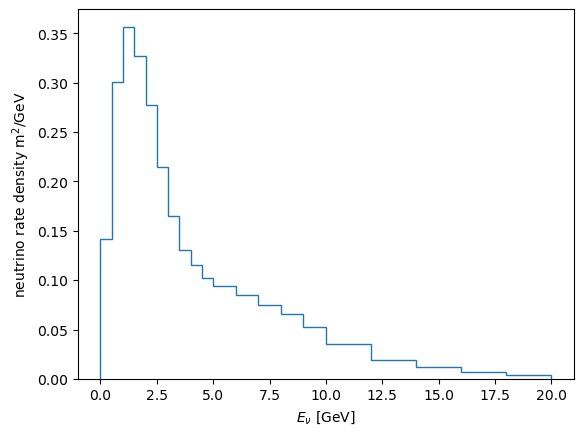

In [5]:
import matplotlib.pyplot as plt

probe_flux_count_density.spectrum.mpl().hist(histtype="step")
plt.xlabel(r"$E_{\nu}$ [GeV]")
plt.ylabel(r"neutrino rate density m$^{2}$/GeV")
plt.show()

In [6]:
%%bash
# only generate if we haven't already
if [ ! -e events_for_nova_nueccinc.hepmc3.gz ]; then
    neut-quickstart -t C -s nue \
                -f flux_for_nova_nueccinc.root,flux_count \
                -n 100000 \
                -o events_for_nova_nueccinc.hepmc3.gz
fi

[OPT]: Generating events on: C
[OPT]: Generating nue events.
[OPT]: Generating events with the a flux distribution according to flux_for_nova_nueccinc.root,flux_count
[OPT]: Processing/Generating 100000 NEUT events.
[OPT]: Writing final output to events_for_nova_nueccinc.hepmc3.gz
[NEUT] Running in /tmp/neut-quickstart/16026
[INFO]: Reading from neutvect.root
[INFO]: Reading flux information from flux_for_nova_nueccinc.root:flux_count
[INFO]: Not mono-energetic, so cannot infer FATX from first event.
[INFO]: Calculated FATX from input file file as: 0.0445912 pb/Nucleon
Converting 100000/100000


## Build the Comparison

In [2]:
neut_events = pn.EventSource("events_for_nova_nueccinc.hepmc3.gz")
if not neut_events:
    print("Failed to read NEUT file")

In [8]:
neut_comparison = ana.process(neut_events)
print(f"neut likelihood = {neut_comparison.likelihood()}")

neut likelihood = 9.304973059332665


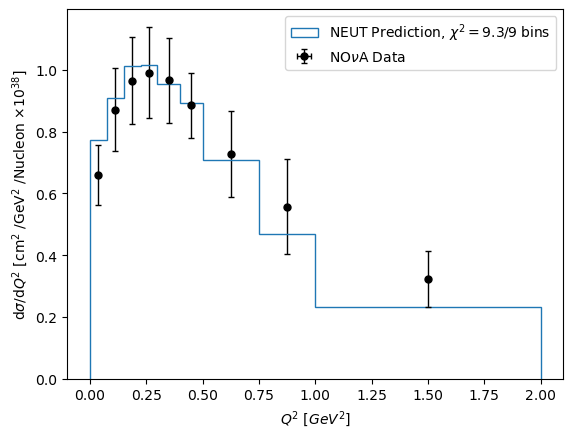

In [9]:
## 1D

import matplotlib.pyplot as plt

nbins = len(neut_comparison.predictions[0].binning.bins)

neut_comparison.data[0].mpl().data_hist(label=r"NO$\nu$A Data")
neut_comparison.predictions[0].mpl().hist(label=r"NEUT Prediction, $\chi^{2} = " \
                                     + f"{neut_comparison.likelihood():.3}" \
                                     + f"/{nbins}$ bins", histtype="step")

plt.legend()
plt.show()

In [ ]:
ana = hepdata_rec.analysis("diffxsec_electron_theta_energy")

In [ ]:
neut_comparison = ana.process(neut_events)


$\mathrm{cos}(\theta_{e})$
$\mathrm{cos}(\theta_{e})$
$\mathrm{cos}(\theta_{e})$
$\mathrm{cos}(\theta_{e})$


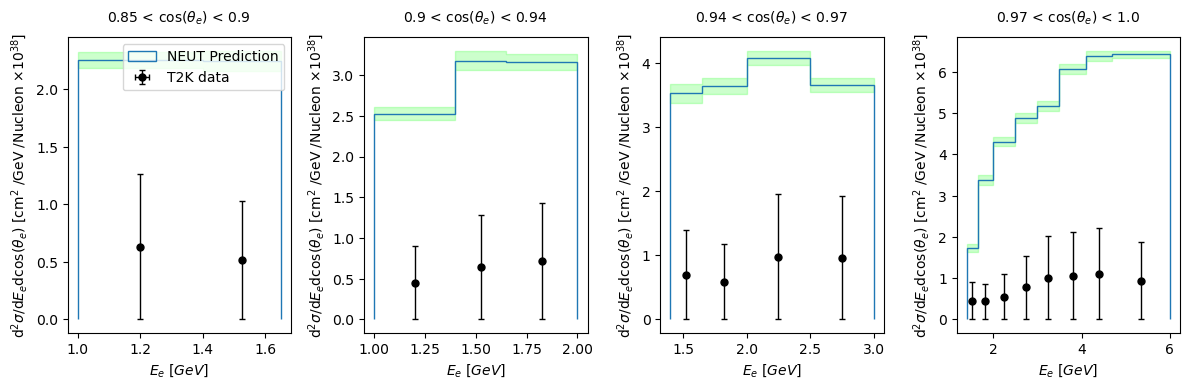

In [3]:
## 2D
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,4, figsize=(12,4))

d_x_bin_centers = pn.Binning.get_bin_centers1D(neut_comparison.data[0].project(0).binning.bins)
d_x_bin_edges = pn.Binning.get_bin_edges1D(neut_comparison.data[0].project(0).binning.bins)

for i in range(len(d_x_bin_centers)):
    d_slice = neut_comparison.data[0].slice(0,d_x_bin_centers[i])
    p_slice = neut_comparison.predictions[0].slice(0,d_x_bin_centers[i])
    
    d_slice.mpl().data_hist(plot_axis=axes[i], label="T2K data")
    p_slice.mpl().hist(histtype="step", plot_axis=axes[i], errorband_color="#0F03", label="NEUT Prediction")

    x_proj_prettyname = ana.get_projections()[0].prettyname
    print(x_proj_prettyname)
    x_proj_unit = ana.get_projections()[0].units
    
    axes[i].text(0.5,1.05,f"{d_x_bin_edges[i]} < {x_proj_prettyname} < {d_x_bin_edges[i+1]} {x_proj_unit}",
                horizontalalignment="center",transform = axes[i].transAxes)
    
    if not i:
        axes[i].legend()

fig.tight_layout()
fig.show()